In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from scipy import optimize

from sklearn.model_selection import train_test_split

from scipy.io import savemat, loadmat

from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=1)


with open('normal_pneumonia_train.npy', 'rb') as f:
    x_ray_features = np.load(f)
    x_ray_labels = np.load(f)

    
X_train, X_test, y_train, y_test = train_test_split(x_ray_features, x_ray_labels, 
                                                    test_size=2000, random_state=242)

classes = ['Normal', 'Pneumonia']

X_all = np.concatenate((X_train,X_test))

n = X_train.shape[0]


print(x_ray_features.shape)
print(X_train.shape, y_train.shape, X_train.dtype, np.sum(y_train==0), np.sum(y_train==1))
print(X_test.shape, y_test.shape, X_test.dtype, np.sum(y_test==0), np.sum(y_test==1))
    
%matplotlib notebook

%load_ext autoreload
%autoreload 2

(13389, 1024)
(11389, 1024) (11389,) float32 6775 4614
(2000, 1024) (2000,) float32 1191 809
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
from matplotlib.lines import Line2D
from scipy.spatial import ConvexHull

legend_elements = [Line2D([0], [0], marker='.', lw=0, color='k', label='Inside'),
                   Line2D([0], [0], marker='.', lw=0, color='r', label='Outside'),
                  ]
import cvxpy as cp

def is_inside(x,verts, verbose=False):
    n = len(verts)
    
    w = cp.Variable(n)
    
    problem = cp.Problem( cp.Minimize(cp.sum_squares(verts.T @ w - x)),
        [w>=0, cp.sum(w)==1]) 
    
    #try:
    problem.solve(solver=cp.ECOS, verbose=verbose)
    #except:
    #    return 3
    
    w = w.value
    
    z = np.sum((verts.T @ w - x)**2)
    
    #print(w, z)
    
    if z<10**-10:
        return 1
    else:
        return 0
    
def verts_points_inside(vert_points, scale=0.95):
    mn = np.mean(vert_points, axis=0)
    
    verts_points_inside = []
    for i in range(len(vert_points)):
        unit = vert_points[i] - mn
        unit = mn + unit * scale
        verts_points_inside.append(unit)
        
    return np.array(verts_points_inside)

def plot_umap(y_umap, y_train, umap_test=None, y_test=None,
              rot_angle = 0, x_neg = 1, y_neg = 1,
              filename=None, if_legend=False, loc='upper right',
              ifSave=True, solver_verbose=False):
    
    colors = ['c', 'g', 'b', 'k']
    #markers = ['.', '+', '*', 'o']
    markers = ['.', '.', '.']
    markers_2 = ['.', '.', '.']
    colors_2 = ['r', 'm', 'k']

    #rot_angle = -55#np.pi - np.arctan(m2) #-60 for saved model, -50 for seed 100
    theta = (rot_angle) * np.pi / 180
    rot_mat = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

    mn = np.mean(y_umap, axis=0)

    Y = y_umap - mn
    Y = rot_mat.dot(Y.T).T
    
    hull = ConvexHull(Y)
    verts_0 = hull.vertices
    vert_points = Y[verts_0]
    verts = np.append( verts_0, hull.vertices[0] ) 
    
    scaled_verts = verts_points_inside(vert_points)
    scaled_verts_plot = np.append(scaled_verts, scaled_verts[0]).reshape(scaled_verts.shape[0]+1,-1)

    print(vert_points)
    markersize = 5

    plt.figure()
    #plt.title('UMAP - Non Parametric')
    
    no_of_out = 0
    no_of_out_scaled = 0
    
    if umap_test is not None:
        test_points = umap_test - mn
        test_points = rot_mat.dot(test_points.T).T
        
        for i in range(test_points.shape[0]):
            y_in = is_inside(test_points[i], vert_points, verbose=solver_verbose)
            
            no_of_out += 1-y_in
            
            y_in_2 = is_inside(test_points[i], scaled_verts_plot, verbose=solver_verbose)
            no_of_out_scaled += 1-y_in_2
            #print(y_in)
            
            if y_in_2==1:
                plt.plot(x_neg*test_points[i,0], y_neg*test_points[i,1], 
                    color = 'k', #colors_2[y_test[i]], 
                    marker = markers_2[y_test[i]],#) #,
                    markersize=markersize)
            else:
                plt.plot(x_neg*test_points[i,0], y_neg*test_points[i,1], 
                    color = 'r', #colors_2[y_test[i]], 
                    marker = markers_2[y_test[i]],#) #,
                    markersize=markersize)
    plt.plot(x_neg*Y[verts,0], y_neg*Y[verts,1], 'k--', lw=2, alpha=0.5)
    plt.plot(x_neg*scaled_verts_plot[:,0], y_neg*scaled_verts_plot[:,1], 'r--', lw=2, alpha=0.5)
    
    
    plt.xticks([],[])
    plt.yticks([],[])
    
    if if_legend:
        plt.legend(handles=legend_elements, loc=loc)
    
    if ifSave:
        plt.savefig('Pneumonia_SH_FIGURES_30_Apr_2023/'+filename, bbox_inches='tight', dpi=400)
        
    print('Total No of Points Outside the Hull: ', no_of_out)
    print('Total No of Points Outside the Hull_2: ', no_of_out_scaled)
    
    return


In [36]:
import numba
from numba import prange

@numba.jit(nopython=True, parallel=True)
def get_first_order_graph(X,n_neighbors):
    
    N = X.shape[0]
    
    dist = np.zeros((N, N), dtype=np.float32)
    #euclidean_distances(X_train, squared = False)

    sort_idx = np.zeros((N,n_neighbors), dtype=np.int32)
    
    for i in range(N):
        if (i+1)%10000 == 0:
            print('Completed ', i+1, ' of ', N)
        
        for j in prange(i+1,N):
            dist[i,j] = np.sum( (X[i]-X[j])**2 )
            dist[j,i] = dist[i,j]
        
        sort_idx[i,:] = np.argsort(dist[i,:])[1:n_neighbors+1]
    
    return sort_idx, dist

@numba.jit(nopython=True, parallel=True)
def my_trustworthiness(Y,sort_idx,K):
    N = Y.shape[0]

    val = 0.0
    for i in prange(N):
        dist = np.sum((Y - Y[i,:])**2,axis=1)
        
        sort_idy = np.argsort(dist)[1:]
        for j in prange(K):
            r_0 = np.argwhere(sort_idy[j]==sort_idx[i,:])

            r = r_0[0,0] 

            r_v = r - K + 1
            if r_v>0:
                val += r_v

    val = val * 2.0 / ( N*K * (2*N - 3*K - 1.0))

    
    return 1 - val



<h1>UMAP</h1>

None


<IPython.core.display.Javascript object>


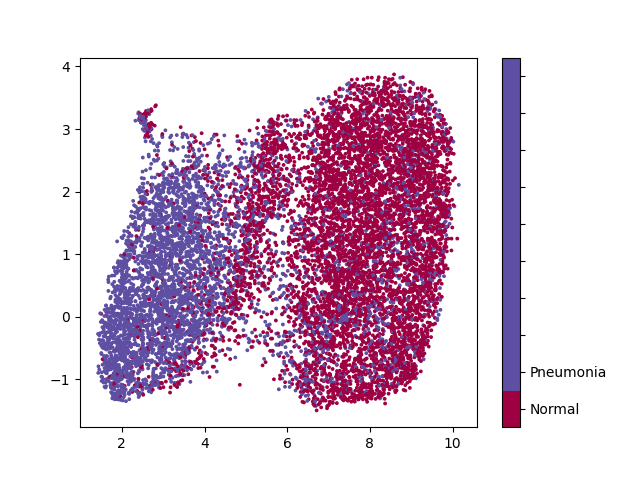

In [40]:
import umap

np.random.seed(100)
ump = umap.UMAP(n_neighbors=30,
        min_dist=0.1,
        n_components=2,
        random_state=100,
        metric= 'euclidean')

print(ump.n_epochs)

y_umap = ump.fit_transform(X_train)
y_umap_test = ump.transform(X_test)

plt.figure()
plt.scatter(y_umap[:,0], y_umap[:,1], c=y_train, s=3.0, cmap='Spectral')

cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)

[[-3.75719047  2.23951411]
 [-3.83407283  2.10546708]
 [-4.68544388 -0.97382551]
 [-4.7382555  -1.30341053]
 [-4.73365688 -1.92717123]
 [-4.65113068 -2.05608463]
 [-4.58004904 -2.14871359]
 [-4.39303589 -2.33395863]
 [-4.33443832 -2.34877563]
 [-4.06146049 -2.3784256 ]
 [ 0.54955959 -2.52640724]
 [ 2.20566702 -2.41608524]
 [ 2.80414724 -2.16670609]
 [ 3.06989908 -1.90352726]
 [ 3.47049379 -1.08339381]
 [ 3.54414892 -0.91793412]
 [ 3.95113897  0.22047377]
 [ 3.98744249  1.07922649]
 [ 3.85801458  1.77027941]
 [ 3.78096437  1.98679566]
 [ 3.27999258  2.5811832 ]
 [ 2.63503313  2.80084109]
 [ 2.42170954  2.84529734]
 [ 1.78216124  2.7932322 ]
 [-3.33854365  2.35167074]]


<IPython.core.display.Javascript object>


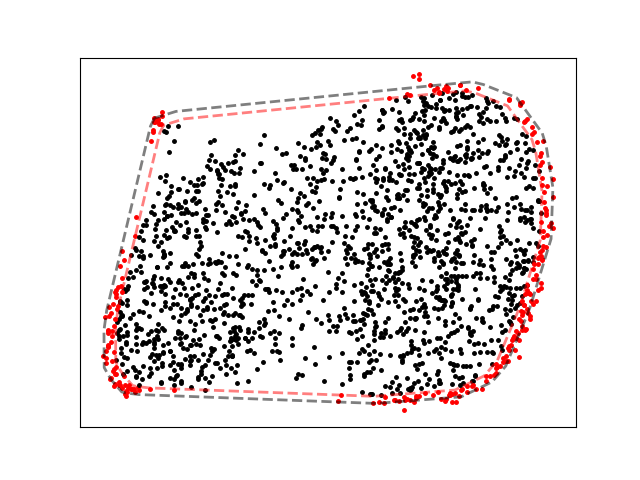

Total No of Points Outside the Hull:  40
Total No of Points Outside the Hull_2:  245


In [41]:
plot_umap(y_umap, y_train, y_umap_test, y_test,
              rot_angle = 0, x_neg = 1, y_neg = 1,
              filename='pneu_umap.png', if_legend=False, loc='upper left',
              ifSave=True)

<IPython.core.display.Javascript object>


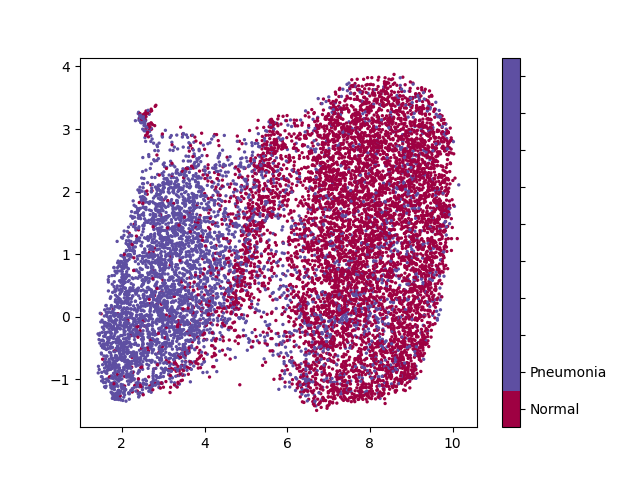

In [42]:
plt.figure()
plt.scatter(y_umap[:,0], y_umap[:,1], c=y_train, s=2, cmap='Spectral')

cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)

<h1>Neg Sampling: 3</h1>

None


<IPython.core.display.Javascript object>


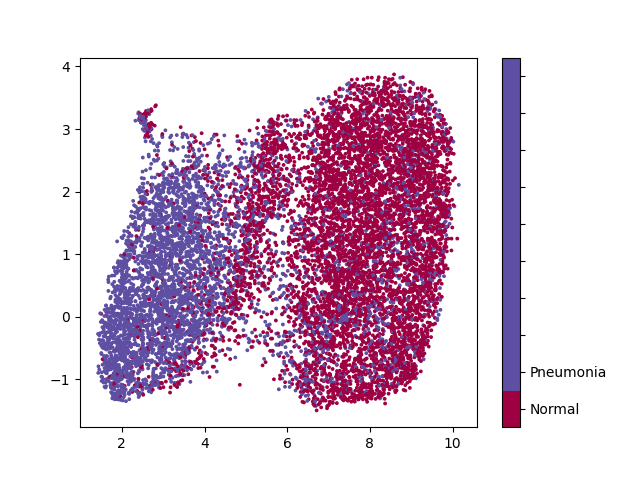

In [43]:
import umap

np.random.seed(100)
ump = umap.UMAP(n_neighbors=30,
        min_dist=0.1,
        n_components=2,
        random_state=100,
        #n_epochs = 4000,
        metric= 'euclidean')

print(ump.n_epochs)


y_umap = ump.fit_transform(X_train)
ump.negative_sample_rate = 3
y_umap_test = ump.transform(X_test)

plt.figure()
plt.scatter(y_umap[:,0], y_umap[:,1], c=y_train, s=3.0, cmap='Spectral')

cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)

[[-3.75719047  2.23951411]
 [-3.83407283  2.10546708]
 [-4.68544388 -0.97382551]
 [-4.7382555  -1.30341053]
 [-4.73365688 -1.92717123]
 [-4.65113068 -2.05608463]
 [-4.58004904 -2.14871359]
 [-4.39303589 -2.33395863]
 [-4.33443832 -2.34877563]
 [-4.06146049 -2.3784256 ]
 [ 0.54955959 -2.52640724]
 [ 2.20566702 -2.41608524]
 [ 2.80414724 -2.16670609]
 [ 3.06989908 -1.90352726]
 [ 3.47049379 -1.08339381]
 [ 3.54414892 -0.91793412]
 [ 3.95113897  0.22047377]
 [ 3.98744249  1.07922649]
 [ 3.85801458  1.77027941]
 [ 3.78096437  1.98679566]
 [ 3.27999258  2.5811832 ]
 [ 2.63503313  2.80084109]
 [ 2.42170954  2.84529734]
 [ 1.78216124  2.7932322 ]
 [-3.33854365  2.35167074]]


<IPython.core.display.Javascript object>


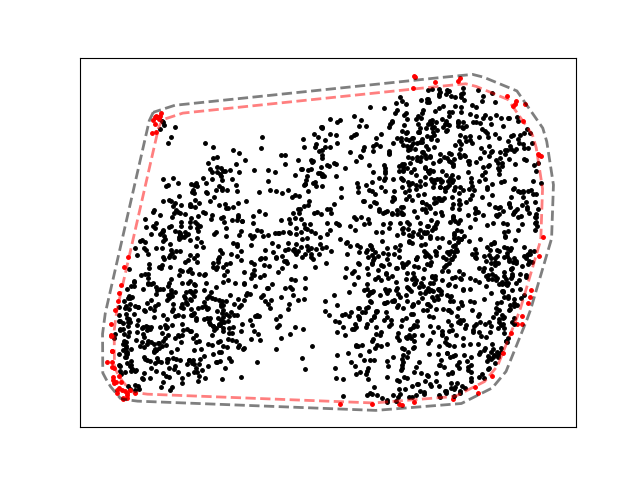

Total No of Points Outside the Hull:  2
Total No of Points Outside the Hull_2:  79


In [44]:
plot_umap(y_umap, y_train, y_umap_test, y_test,
              rot_angle = 0, x_neg = 1, y_neg = 1,
              filename='pneu_umap_neg_3.png', if_legend=False)

<h1>Neg Sampling=1</h1>

None


<IPython.core.display.Javascript object>


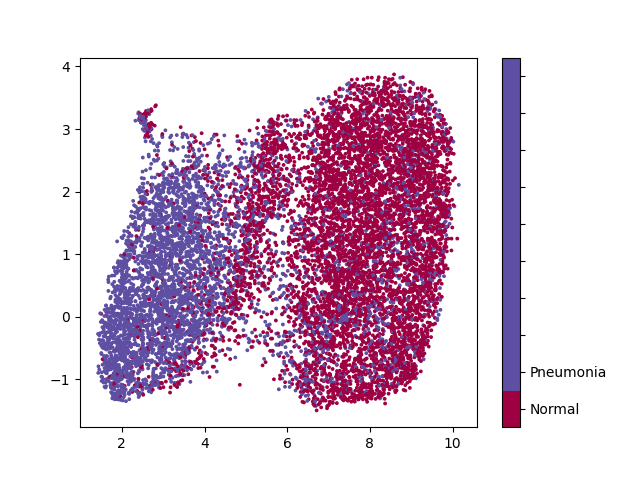

In [45]:
import umap

np.random.seed(100)
ump = umap.UMAP(n_neighbors=30,
        min_dist=0.1,
        n_components=2,
        random_state=100,
        metric= 'euclidean')

print(ump.n_epochs)

#ump.negative_sample_rate = 0

y_umap = ump.fit_transform(X_train)

ump.negative_sample_rate = 1

y_umap_test = ump.transform(X_test)

plt.figure()
plt.scatter(y_umap[:,0], y_umap[:,1], c=y_train, s=3.0, cmap='Spectral')

cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)

[[-3.75719047  2.23951411]
 [-3.83407283  2.10546708]
 [-4.68544388 -0.97382551]
 [-4.7382555  -1.30341053]
 [-4.73365688 -1.92717123]
 [-4.65113068 -2.05608463]
 [-4.58004904 -2.14871359]
 [-4.39303589 -2.33395863]
 [-4.33443832 -2.34877563]
 [-4.06146049 -2.3784256 ]
 [ 0.54955959 -2.52640724]
 [ 2.20566702 -2.41608524]
 [ 2.80414724 -2.16670609]
 [ 3.06989908 -1.90352726]
 [ 3.47049379 -1.08339381]
 [ 3.54414892 -0.91793412]
 [ 3.95113897  0.22047377]
 [ 3.98744249  1.07922649]
 [ 3.85801458  1.77027941]
 [ 3.78096437  1.98679566]
 [ 3.27999258  2.5811832 ]
 [ 2.63503313  2.80084109]
 [ 2.42170954  2.84529734]
 [ 1.78216124  2.7932322 ]
 [-3.33854365  2.35167074]]


<IPython.core.display.Javascript object>


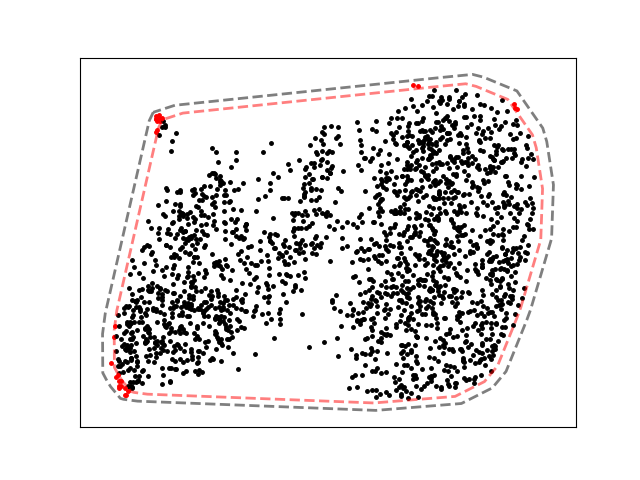

Total No of Points Outside the Hull:  0
Total No of Points Outside the Hull_2:  30


In [46]:
plot_umap(y_umap, y_train, y_umap_test, y_test,
              rot_angle = 0, x_neg = 1, y_neg = 1,
              filename='pneu_umap_neg_1.png', if_legend=False)

<h1>Combined Train and Test Data<h1>

<IPython.core.display.Javascript object>


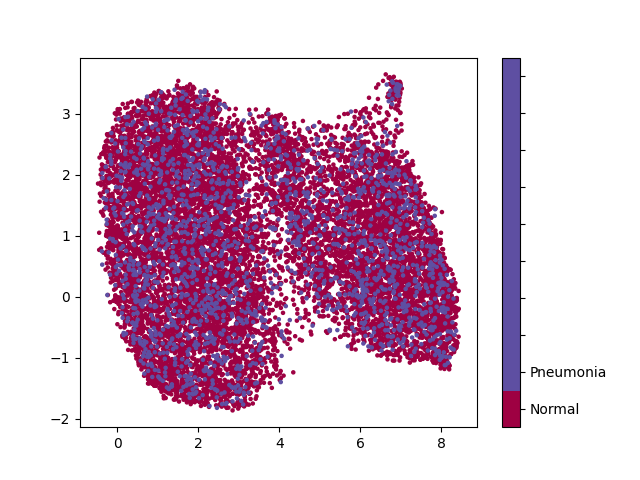

In [47]:
import umap

np.random.seed(100)
ump = umap.UMAP(n_neighbors=30,
        min_dist=0.1,
        n_components=2,
        random_state=100,
        metric= 'euclidean')

t_umap_all = ump.fit_transform(X_all)

y_all = np.concatenate((np.zeros(X_train.shape[0]), np.ones(X_test.shape[0])))

y_umap = t_umap_all[:X_train.shape[0]]
y_umap_test = t_umap_all[X_train.shape[0]:]

plt.figure()
plt.scatter(t_umap_all[:,0], t_umap_all[:,1], c=y_all, s=5, cmap='Spectral')

cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)

[[ 4.67676404 -1.58036107]
 [ 4.49512528 -0.23563869]
 [ 3.85057131  2.02762097]
 [ 3.83994106  2.0482501 ]
 [ 3.70870789  2.154205  ]
 [ 3.51881513  2.22744918]
 [-1.54930727  3.01330822]
 [-2.96831093  2.87856975]
 [-3.10593567  2.81698199]
 [-3.18632413  2.76214412]
 [-3.43551498  2.45840745]
 [-3.68486531  2.11433936]
 [-3.79520852  1.70008419]
 [-3.95595809  0.62524176]
 [-3.8733154  -0.1403741 ]
 [-3.83694124 -0.26708054]
 [-3.72404704 -0.65312104]
 [-3.63699716 -0.87845637]
 [-3.53605398 -1.11369732]
 [-3.1474359  -1.74117349]
 [-2.80499386 -2.04807106]
 [-2.16722221 -2.25732101]
 [-1.92270734 -2.33091989]
 [-1.16575273 -2.53811224]
 [ 4.22415894 -2.80538682]
 [ 4.46170077 -2.48159782]
 [ 4.50198456 -2.41503555]
 [ 4.54607822 -2.3180957 ]
 [ 4.62971824 -1.86861178]]


<IPython.core.display.Javascript object>


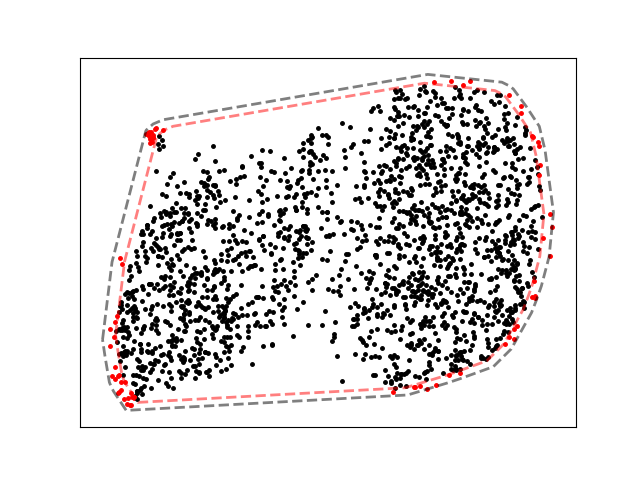

Total No of Points Outside the Hull:  1
Total No of Points Outside the Hull_2:  76


In [48]:
plot_umap(y_umap, y_train, y_umap_test, y_test,
              rot_angle = -10, x_neg = -1, y_neg = 1,
              filename='pneu_umap_no_comb.png', if_legend=False)

<h1>UMAP CE</h1>

In [49]:
from scipy.io import loadmat

d = loadmat('nets_pneumonia_UMAP_CE/test_data39.mat')
t_ce = d['Y'].copy()
t_ce_test = d['Y_test'].copy()
t_ce_tr_te = np.concatenate((d['Y'],d['Y_test'])).copy()


<IPython.core.display.Javascript object>


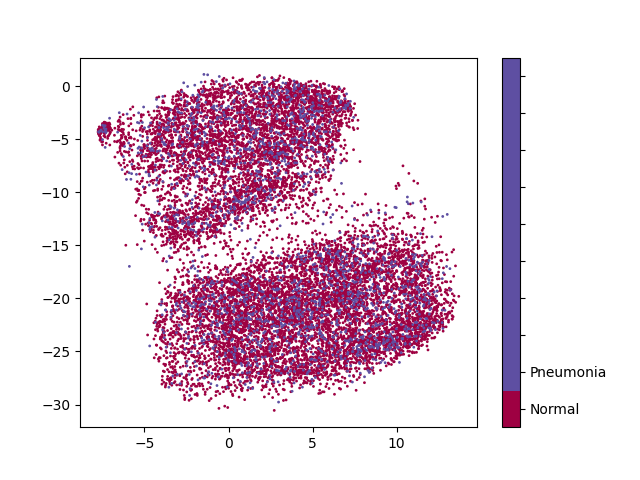

In [50]:
plt.figure()
plt.scatter(t_ce_tr_te[:,0], t_ce_tr_te[:,1], c=y_all, s=1, cmap='Spectral')

cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)

[[ -3.49560654   9.390914  ]
 [-13.24281226   7.48062326]
 [-13.48111468   7.21036491]
 [-14.33731844   6.08770567]
 [-15.39500237   4.09496185]
 [-15.75067867   2.93116486]
 [-16.03994603   0.82388217]
 [-16.02278501   0.07421033]
 [-16.0037305   -0.3517379 ]
 [-15.34789316  -3.37414477]
 [-14.84155694  -5.11341135]
 [-13.89022723  -7.13340101]
 [-13.79169558  -7.26369087]
 [-13.53607982  -7.53004208]
 [-13.29398877  -7.6603811 ]
 [-13.09151865  -7.72471923]
 [-12.9176559   -7.74986999]
 [  6.14967319  -9.82749932]
 [  8.33214724 -10.00343886]
 [ 10.84583471 -10.20443302]
 [ 11.15913493 -10.07787388]
 [ 12.60479167  -9.27232681]
 [ 13.92838375  -7.51687059]
 [ 14.96648824  -4.38948145]
 [ 14.39827687   0.8056678 ]
 [ 11.82908302   5.92121838]
 [ 10.35387364   7.24954011]
 [  9.39310479   8.07220606]
 [  9.18915388   8.17633982]
 [  7.42448395   8.99658671]
 [  4.60212552   9.55129746]
 [  3.09773844   9.83926383]
 [ -0.19278281   9.72501781]]


<IPython.core.display.Javascript object>


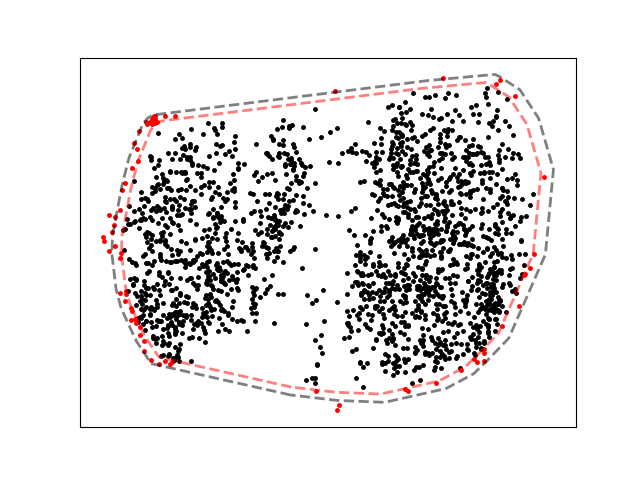

Total No of Points Outside the Hull:  13
Total No of Points Outside the Hull_2:  78


In [51]:
plot_umap(t_ce, y_train, t_ce_test, y_test,
              rot_angle = 75, x_neg = 1, y_neg = -1,
              filename='pneu_pumap_ce.png', if_legend=False)

<h1>UMAP MSE</h1>

In [52]:
from scipy.io import loadmat

d = loadmat('nets_MSE_UMAP_pneumonia/test_data19.mat')
t_mse = d['Y'].copy()
t_mse_test = d['Y_test'].copy()
t_mse_tr_te = np.concatenate((d['Y'],d['Y_test'])).copy()


<IPython.core.display.Javascript object>


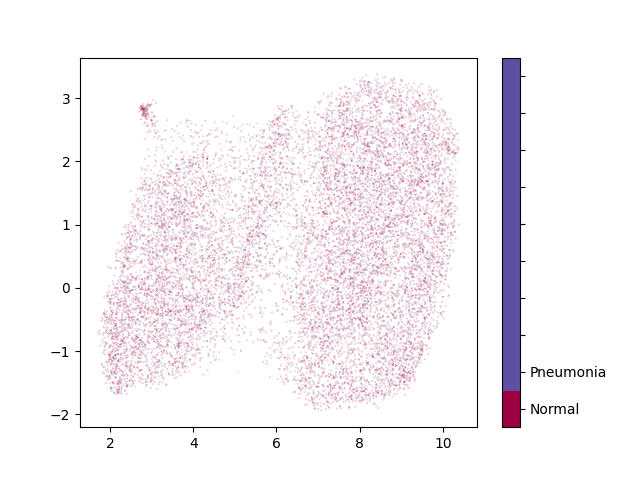

In [53]:
plt.figure()
plt.scatter(t_mse_tr_te[:,0], t_mse_tr_te[:,1], c=y_all, s=0.01, cmap='Spectral')

cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)

[[-4.52383137 -0.27480546]
 [-4.76055384 -1.31553483]
 [-4.67079115 -1.82619619]
 [-4.64539194 -1.9498508 ]
 [-4.56266451 -2.11436796]
 [-4.43711472 -2.23618031]
 [-4.31870461 -2.29127288]
 [ 0.60464716 -2.54596424]
 [ 1.97414732 -2.50831151]
 [ 2.61795759 -2.29829693]
 [ 2.85261679 -2.07464194]
 [ 3.17075682 -1.65819502]
 [ 3.54516268 -1.09429979]
 [ 3.67136621 -0.72475028]
 [ 3.90300989  0.3927049 ]
 [ 3.89925337  1.5801208 ]
 [ 3.87404394  1.81910896]
 [ 3.47548151  2.37538743]
 [ 3.37647295  2.51271844]
 [ 3.20096731  2.56462884]
 [ 3.00814104  2.61593294]
 [ 1.94223356  2.76359773]
 [ 1.6795001   2.7551713 ]
 [-3.42788839  2.35541749]
 [-3.73672771  2.26380658]
 [-3.74936724  2.2313273 ]]


<IPython.core.display.Javascript object>


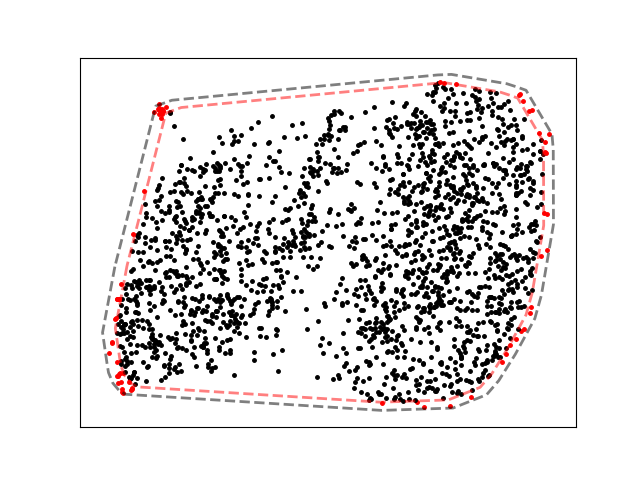

Total No of Points Outside the Hull:  4
Total No of Points Outside the Hull_2:  70


In [54]:
plot_umap(t_mse, y_train, t_mse_test, y_test,
              rot_angle = 0, x_neg = 1, y_neg = 1,
              filename='pneu_pumap_mse.png', if_legend=False)

<h1>UMAP CEMSE</h1>

In [55]:
from scipy.io import loadmat

d = loadmat('nets_MSE_CE_UMAP_peumonia/test_data19.mat')
t_cemse = d['Y'].copy()
t_cemse_test = d['Y_test'].copy()
t_cemse_tr_te = np.concatenate((d['Y'],d['Y_test'])).copy()


<IPython.core.display.Javascript object>


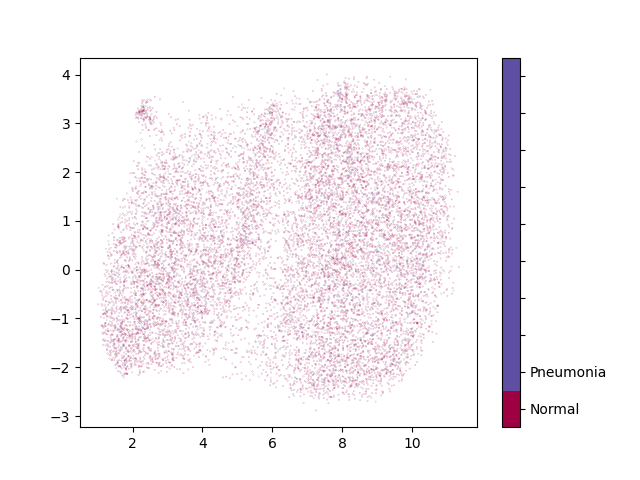

In [56]:
plt.figure()
plt.scatter(t_cemse_tr_te[:,0], t_cemse_tr_te[:,1], c=y_all, s=0.01, cmap='Spectral')

cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)

[[-4.44110572 -3.14954182]
 [ 1.09799525 -3.34379299]
 [ 2.54412207 -3.02159071]
 [ 2.92804128 -2.87410724]
 [ 3.17441695 -2.77177086]
 [ 3.47829494 -2.524397  ]
 [ 3.83951841 -2.16686033]
 [ 4.30248534 -1.65224606]
 [ 4.38906355 -1.47651868]
 [ 4.76058305 -0.61977847]
 [ 4.9044699  -0.05981404]
 [ 4.73766523  1.47560224]
 [ 4.60150333  2.19904254]
 [ 4.38458225  2.60405325]
 [ 3.84960227  3.26684893]
 [ 3.6587765   3.37817371]
 [ 3.45154287  3.48306891]
 [ 3.06639111  3.6417315 ]
 [ 1.95121243  3.60149567]
 [ 0.80017413  3.5471713 ]
 [-4.05674905  2.66124254]
 [-4.4124924   2.55692758]
 [-4.51593576  2.37872837]
 [-4.57087946  2.2406643 ]
 [-5.12328743 -0.28569434]
 [-5.21606605 -0.86388232]
 [-5.30183769 -1.72019764]
 [-5.07708786 -2.53526995]
 [-4.87820689 -2.80105292]
 [-4.61482486 -3.03425435]]


<IPython.core.display.Javascript object>


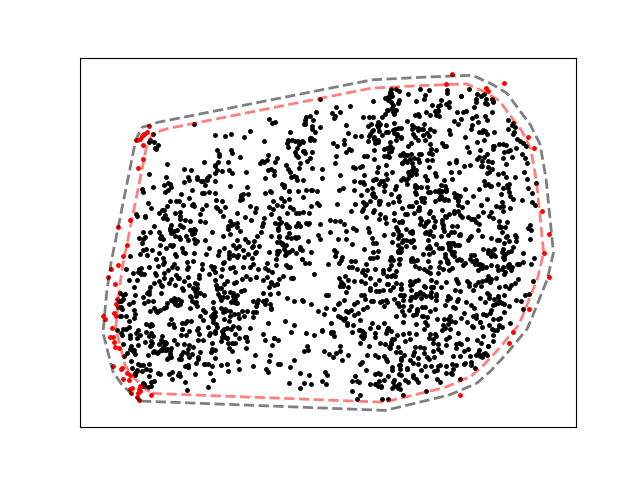

Total No of Points Outside the Hull:  8
Total No of Points Outside the Hull_2:  63


In [57]:
plot_umap(t_cemse, y_train, t_cemse_test, y_test,
              rot_angle = 5, x_neg = 1, y_neg = 1,
              filename='pneu_pumap_cemse.png', if_legend=False)